# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Histogram of Oriented Gradients (HOG)

**1. Explain how (and identify where in your code) you extracted HOG features from the training images.**

The following 4 code cells show extracing HOG features from training images.

The second code cell reads in the car and non-car images as `car_images` and `noncar_images`.

The third code cell draws a sample of 10 images from each of the two sets.

The fourth code cell draws the HOG features for sample images from each sets, using the `hog` function, which calls `sklearn.feature.hog`.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display as display
from IPython.core.pylabtools import figsize, getfigs
import math
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
import numpy as np
import cv2
from tqdm import tqdm

def draw_image(img, title):
    """ Draw a single image with a title """
    f = plt.figure(figsize=(15, 15))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    display(f)
    plt.close(f)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def draw_grid(imgs, suptitle='', img_shape = [100, 100], cols = 2, width = 5, height = None, titles=[]):
    """ Draw a grid of images with a title. """
    rows = math.ceil(len(imgs)/cols)
    if height == None:
        height = int(0.7*(img_shape[0]*rows)*width/(cols*img_shape[1]))
    fig = plt.figure(figsize=(width, height))

    pad = 0.5
    if len(titles) == 0:
        pad = 0.1
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),
                     axes_pad=pad,  # pad between axes in inch.
                     label_mode='L',
                     )
    
    if len(titles) == 2:
        if len(titles[0]) == cols or len(titles[0]) == len(imgs):
            for ax, ax_title in zip(grid, titles[0]):
                ax.set_title(ax_title, fontsize = 12)
        if len(titles[1]) == rows:
            for ax, ax_title in zip(grid[::cols], titles[1]):
                ax.set_ylabel(ax_title, fontsize = 12)
    elif len(titles) == len(imgs):
        for ax, ax_title in zip(grid, titles):
            ax.set_title(ax_title, fontsize = 12)
 
    for i in range(len(imgs)):
        grid[i].imshow(imgs[i], cmap='gray')
        
    plt.suptitle(suptitle, fontsize = 16)
    if height > width:
        fig.subplots_adjust(bottom = 0.1, top= 0.97, hspace=1.5)    
    else:
        fig.subplots_adjust(hspace=1.5)    
   
    plt.show()

def toRGB(img):
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

car_image_paths = glob.glob('./vehicles/*/*.png')
print("# vehicle images:", len(car_image_paths))

noncar_image_paths = glob.glob('./non-vehicles/*/*.png')
print("# non-vehicle images:", len(noncar_image_paths))

def read_images(images):
    out_images = []
    for fname in images:
        img = cv2.imread(fname)
        out_images.append(toRGB(img))
    return out_images

car_images = read_images(car_image_paths)
noncar_images = read_images(noncar_image_paths)

# vehicle images: 8792
# non-vehicle images: 8968


Image shape: (64, 64)


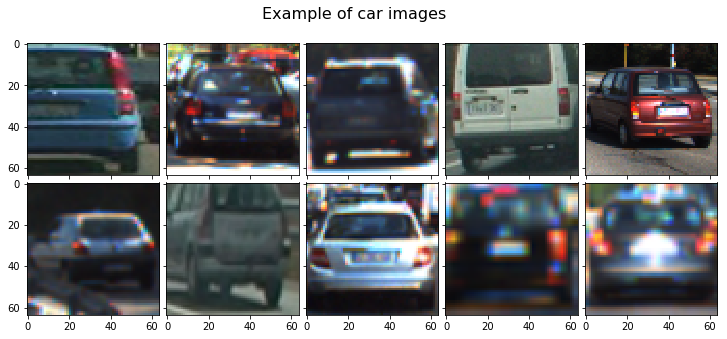

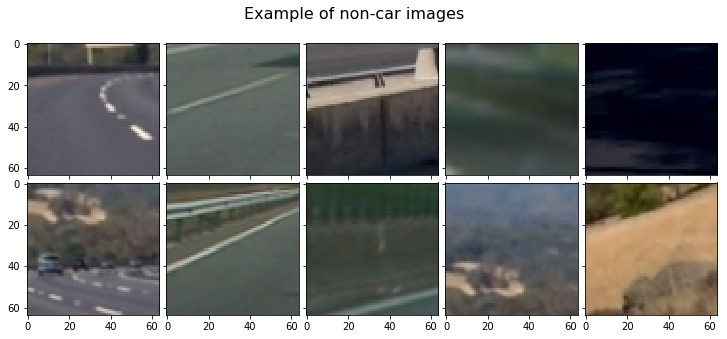

In [3]:
from sklearn.utils import resample
sample_car_imgs = resample(car_images, n_samples = 10)
sample_noncar_imgs = resample(noncar_images, n_samples = 10)
img_shape = sample_car_imgs[0].shape[:2]
print("Image shape:", img_shape)

draw_grid(sample_car_imgs, "Example of car images", img_shape, 5, 20)
draw_grid(sample_noncar_imgs, "Example of non-car images", img_shape, 5, 20)


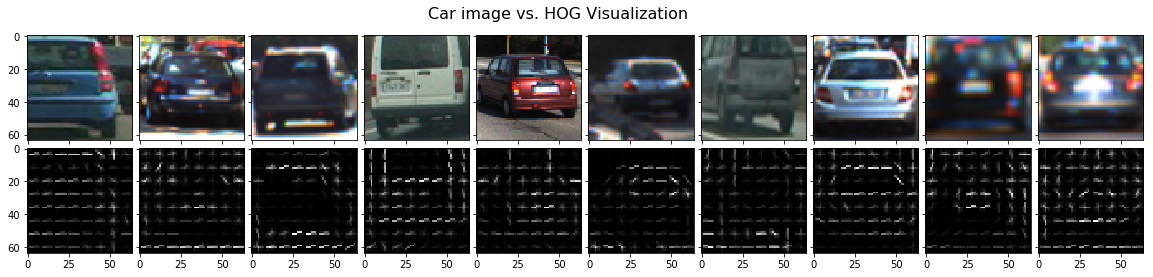

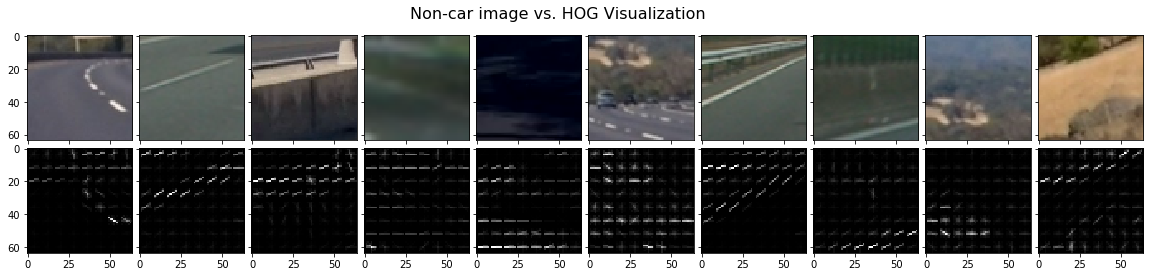

In [4]:
#from skimage.feature import hog
import skimage.feature

# Define a function to return HOG features and visualization
def hog(img, orient=12, pix_per_cell=8, cell_per_block=1, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = skimage.feature.hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = skimage.feature.hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define HOG parameters
orient = 12
pix_per_cell = 8
cell_per_block = 1

flatten = lambda l: [item for sublist in l for item in sublist]

out_car_imgs = []
for img in sample_car_imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_image = hog(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    out_car_imgs.append(hog_image)
    
out_noncar_imgs = []
for img in sample_noncar_imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Call our function with vis=True to see an image output
    features, hog_image = hog(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    out_noncar_imgs.append(hog_image)
    
draw_grid(flatten([sample_car_imgs, out_car_imgs]), "Car image vs. HOG Visualization", img_shape, 10, 30)
draw_grid(flatten([sample_noncar_imgs, out_noncar_imgs]), "Non-car image vs. HOG Visualization", img_shape, 10, 30)


**2. Explain how you settled on your final choice of HOG parameters.**

As shown by the following code cell, I plotted HOG features for several different color spaces (RGB, LUV, YCrCb) and parameters (orientation, pixels per cell, cells per block).

Based on this, I noticed that RGB did a poor job of differentiating between cars and non-cars. There was little difference between the features extracted from the LUV and YCrCb images. Therefore, I decided to use the LUV color space to generate HOG features.

Based on the parameters, I found that increasing the orientation bins from 8 to 10 and from 10 to 12 makes it easier to distinguish the silhouette of the car in the car images. Increasing pixels per cell from 4 to 8 to 12 increased the number of features generated. I decided to settle on the middle-ground option and use 8 pixels per cell.

The final parameters selected were 12 orientation bins, 8 pixels per cell, and 1 cell per block.


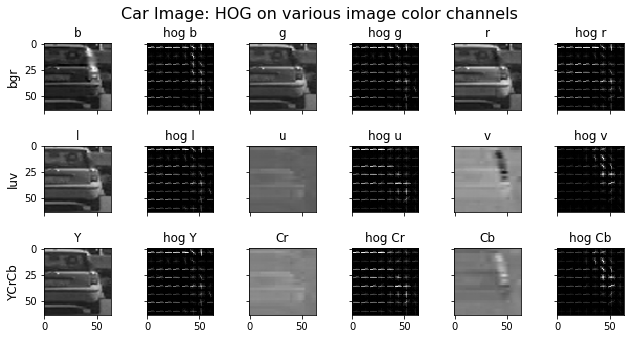

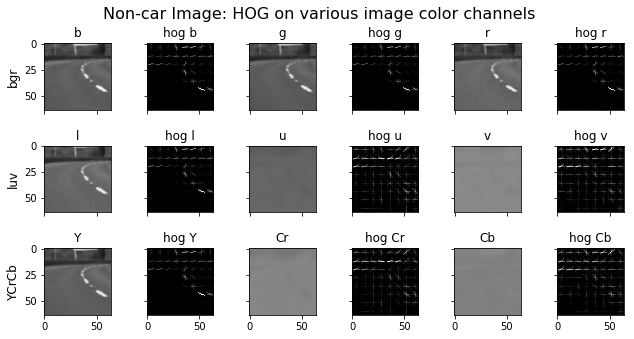

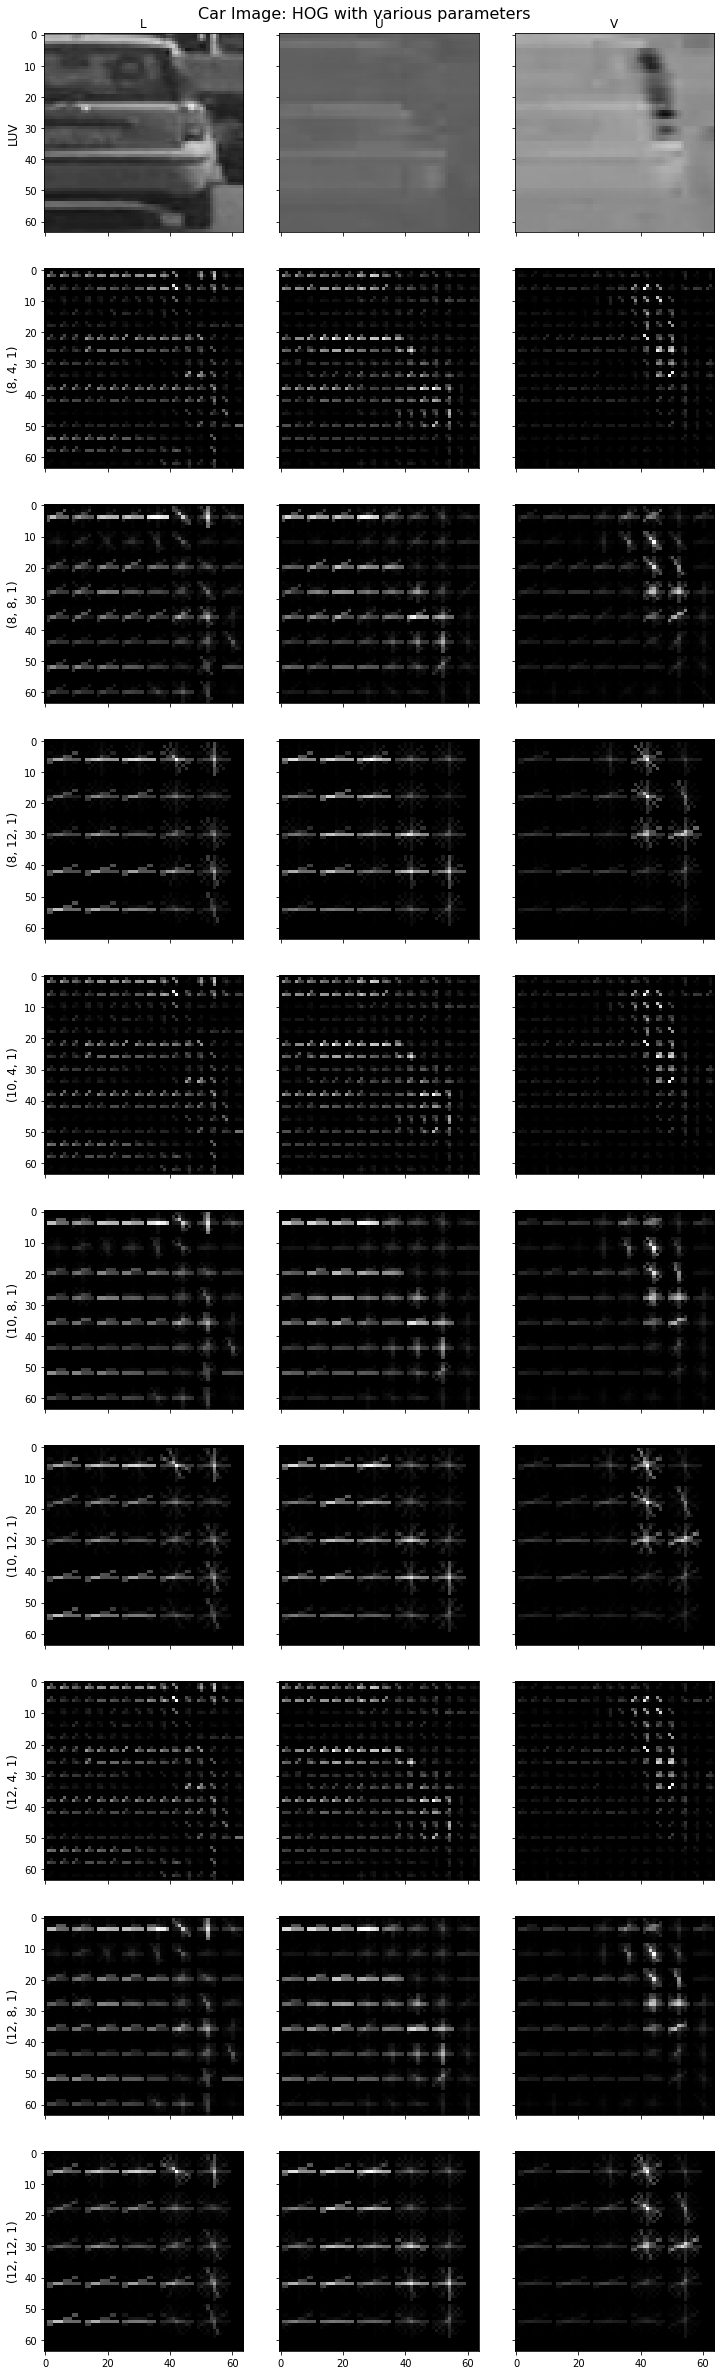

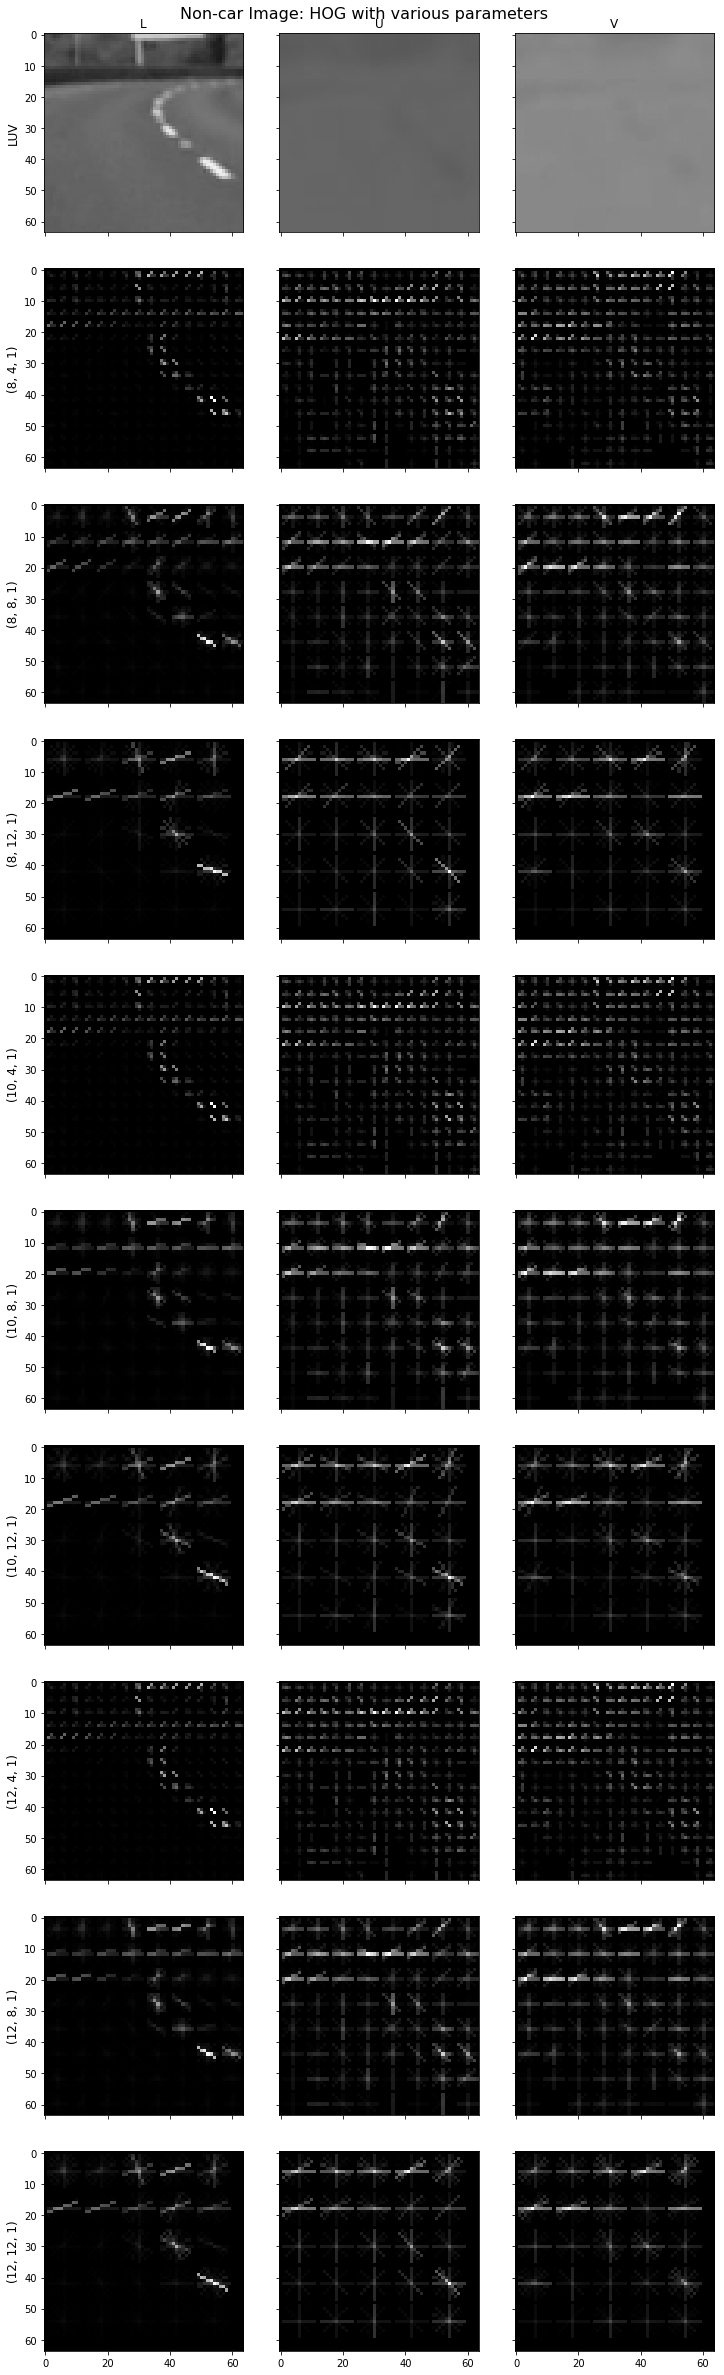

In [5]:
import itertools
sample_car_img = sample_car_imgs[0]
sample_noncar_img = sample_noncar_imgs[0]

def channelToBGR(img):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

def hog_img(img, orient=12, pix_per_cell=8, cell_per_block=1):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features, hog_image = hog(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    return hog_image

def vis_hog_channels(img):
    out_imgs = []
    
    y_titles = ['bgr', 'luv', 'YCrCb']
    img_titles = flatten([(y, 'hog {0}'.format(y)) for y in ['b', 'g', 'r', 'l', 'u', 'v', 'Y', 'Cr', 'Cb']])
    
    b,g,r = cv2.split(img)
    l,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LUV))
    y,cr,cb = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb))
    
    out_imgs.append(channelToBGR(b))
    out_imgs.append(hog_img(channelToBGR(b)))
    out_imgs.append(channelToBGR(g))
    out_imgs.append(hog_img(channelToBGR(g)))
    out_imgs.append(channelToBGR(r))
    out_imgs.append(hog_img(channelToBGR(r)))
    
    out_imgs.append(channelToBGR(l))
    out_imgs.append(hog_img(channelToBGR(l)))
    out_imgs.append(channelToBGR(u))
    out_imgs.append(hog_img(channelToBGR(u)))
    out_imgs.append(channelToBGR(v))
    out_imgs.append(hog_img(channelToBGR(v)))
    
    out_imgs.append(channelToBGR(y))
    out_imgs.append(hog_img(channelToBGR(y)))
    out_imgs.append(channelToBGR(cr))
    out_imgs.append(hog_img(channelToBGR(cr)))
    out_imgs.append(channelToBGR(cb))
    out_imgs.append(hog_img(channelToBGR(cb)))
    
    return out_imgs, [img_titles, y_titles]

def vis_hog_params(img):
    out_imgs = []
    l,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LUV))
    
    x_titles = ['L', 'U', 'V']
    orientations = [8, 10, 12]
    pix_per_cells = [4, 8, 12]
    cells_per_block = [1]
    params = list(itertools.product(orientations, pix_per_cells, cells_per_block))
   
    y_titles = ['LUV'] + params
    
    out_imgs.append(channelToBGR(l))
    out_imgs.append(channelToBGR(u))
    out_imgs.append(channelToBGR(v))
    for param in params:
        out_imgs.append(hog_img(channelToBGR(l), *param))
        out_imgs.append(hog_img(channelToBGR(u), *param))
        out_imgs.append(hog_img(channelToBGR(v), *param))
   
    return out_imgs, [x_titles, y_titles]
    
imgs, titles = vis_hog_channels(sample_car_img)
draw_grid(imgs, "Car Image: HOG on various image color channels", img_shape, 6, 16, None, titles)
    
imgs, titles = vis_hog_channels(sample_noncar_img)
draw_grid(imgs, "Non-car Image: HOG on various image color channels", img_shape, 6, 16, None, titles)
    
imgs, titles = vis_hog_params(sample_car_img)
draw_grid(imgs, "Car Image: HOG with various parameters", img_shape, 3, 16, None, titles) 

imgs, titles = vis_hog_params(sample_noncar_img)
draw_grid(imgs, "Non-car Image: HOG with various parameters", img_shape, 3, 16, None, titles) 

**3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).**

The following 2 code cells are used to train a linear SVC classifier using the `sklearn.svm.LinearSVC` model. The color histogram and binned color features were also used to train the model, in addition to the HOG features, as described in the course notes.

The classifier was trained using an 80/20 split of test/train data. The features were normalized before evaluating.

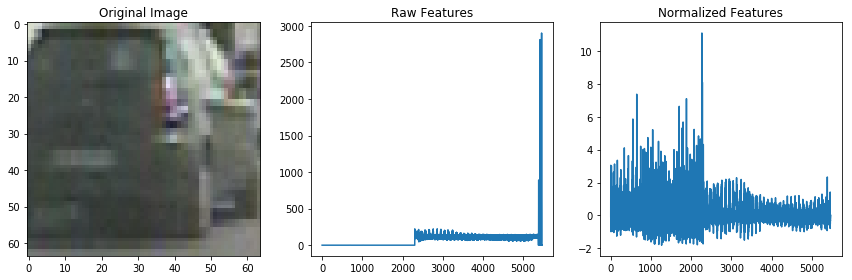

In [6]:
from sklearn.preprocessing import StandardScaler

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(hog(feature_image[:,:,channel], 
                                12, 8, 1, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, spatial_features, hist_features)))
    # Return list of feature vectors
    return features

car_features = extract_features(car_images, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(noncar_images, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car_images))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(car_images[car_ind])
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time

spatial = 32
histbin = 32

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 5472
13.86 Seconds to train SVC...
Test Accuracy of SVC =  0.9958
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.0018 Seconds to predict 10 labels with SVC


## Sliding Window Search

**1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?**

Sliding window search is implemented in the `slide_window` function in the second code cell below.

I searched at scales of 64x64, 96x96, and 128x128 with overlaps of 0.5, 0.75, and 0.75, respectively. The smaller windows are used closer to the horizon, as cars at that location will be further away from the camera and therefore appear smaller.

These window sizes and overlap parameters were tuned by examining the bounding box detections on the test video, which the `find_cars` function in the third code cell outputs (with each size window being a different color). In order to reduce false positives in the video, I wanted to use a threshold function to eliminate regions of the frame where only a single window was matched, so I increased the overlap between the windows in order to generate a larger number of windows and increase the number of windows that will be matched on the actual cars vs. non-car false positives. However, I found that for the 64x64 size windows, using an overlap of 0.75 produced too many windows and slowed down the detections, so I reduced the overlaps for that window size to 0.5.

In [8]:
# http://stackoverflow.com/questions/470690/how-to-automatically-generate-n-distinct-colors
import colorsys

def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return np.array(colors, dtype=float)*255

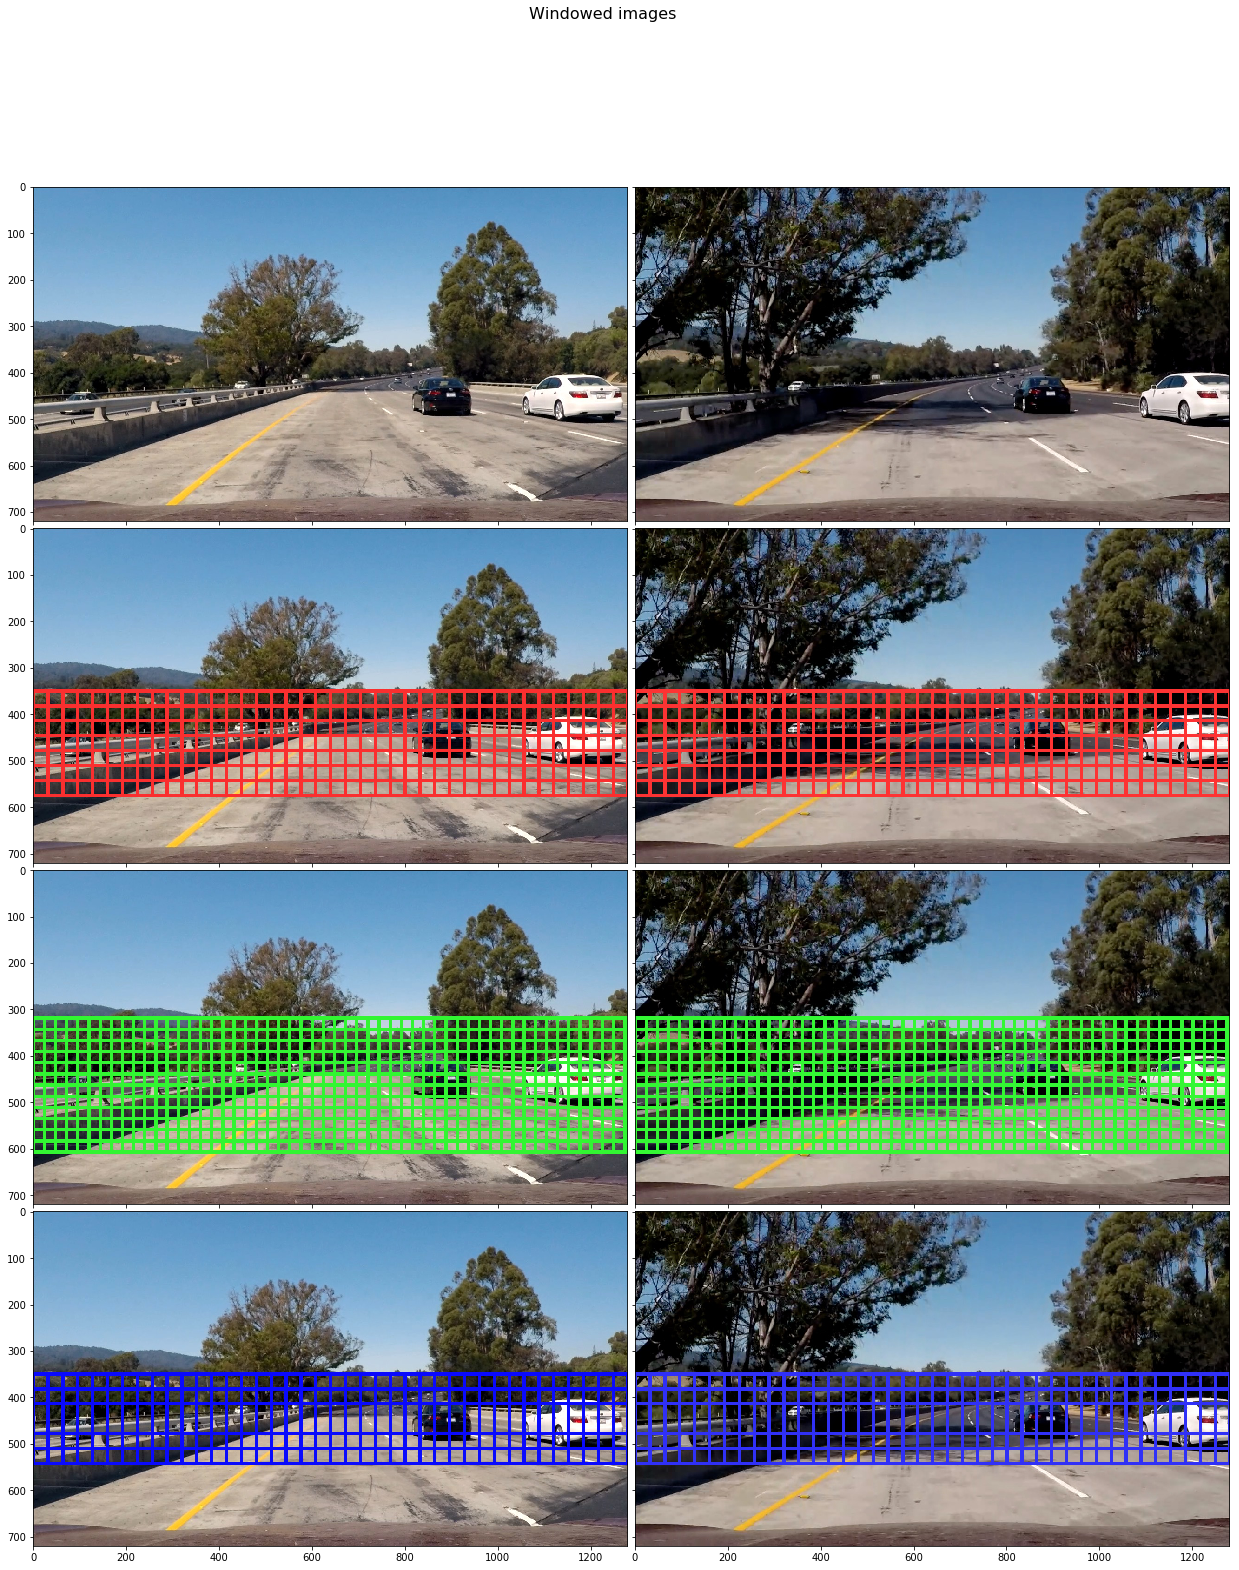

In [18]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = min(startx + xy_window[0], img.shape[1]-1)
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = min(starty + xy_window[1], img.shape[0]-1)
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

test_image_paths = glob.glob('./test_images/*.jpg')
test_images = read_images(test_image_paths)

window_scales = [x*32 for x in [2, 3, 4]]
window_overlaps = [0.5, 0.75, 0.75, 0.75]
window_starts = [350, 320, 350, 464]
window_ends = [580, 580, 500, 600]
windows = []
windows_at_scale = []

for i in range(len(window_scales)):
    scale = window_scales[i]
    windows_at_scale.append(slide_window(img, x_start_stop=[None, None], y_start_stop=[window_starts[i], window_ends[i]], 
                       xy_window=(scale, scale), xy_overlap=(window_overlaps[i], window_overlaps[i])))
    windows += windows_at_scale[i]

windowed_imgs = []
for img in test_images[0:2]:
    windowed_imgs.append(img)
                           
for i in range(len(window_scales)):
    for img in test_images[0:2]:
        window_img = draw_boxes(img, windows_at_scale[i], color=get_colors(len(window_scales))[i], thick=6)    
        windowed_imgs.append(window_img)
    
draw_grid(windowed_imgs, "Windowed images", windowed_imgs[0].shape, len(test_images[0:2]), 32)
    

**2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?**

The following code cell outputs the results of the `find_cars` function on the various test images. In all cases, it detected the cars with several windows. In the final test image, it detected a false positive on the road lane line, but only one window was matched. 

The false positives will be eliminated by thresholding and scanning multiple frames of the video, as described below.

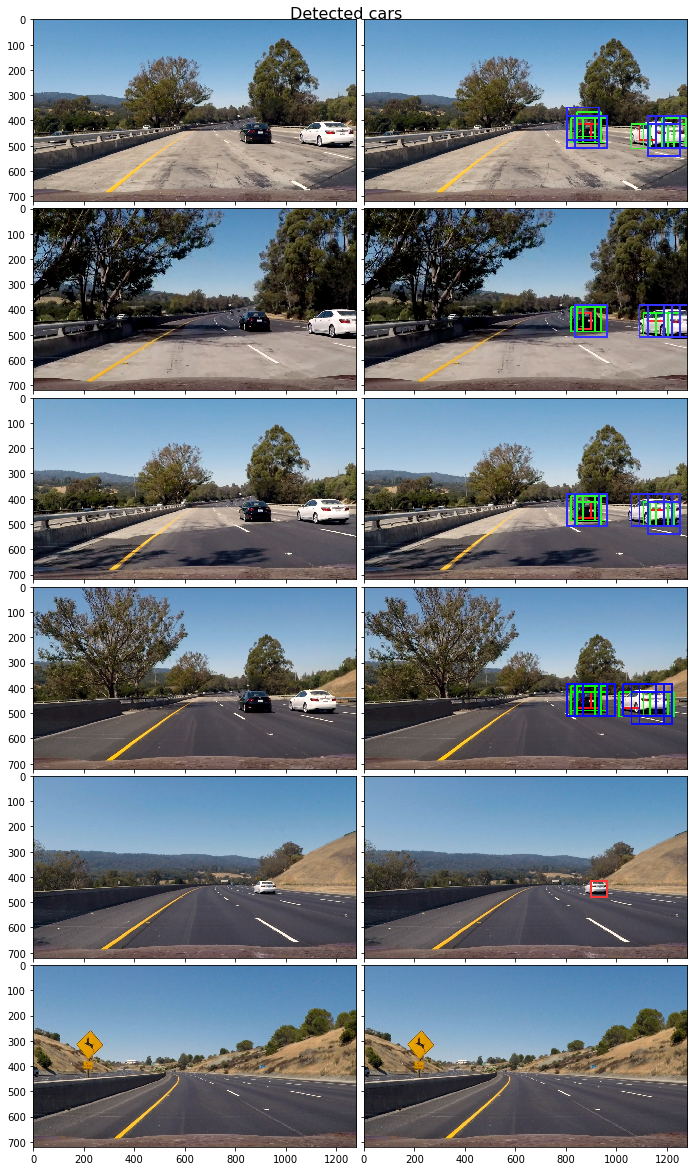

In [19]:
def single_img_features(img, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    return extract_features([img], spatial_size, hist_bins, hist_range)[0]

def find_cars(img, windows):
    out_img = np.copy(img)
    found_windows = []
    for i in range(len(window_scales)):
        hot_windows = search_windows(img, windows_at_scale[i])
        found_windows.append(hot_windows)
        out_img = draw_boxes(out_img, hot_windows, color=get_colors(len(window_scales))[i], thick=6)
    return out_img, flatten(found_windows)
    
def search_windows(img, windows):
    on_windows = []
    for window in windows:
        window_block = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = single_img_features(window_block)
        prediction = svc.predict(X_scaler.transform(np.array(features).reshape(1, -1)))

        if prediction > 0.95:
            on_windows.append(window)
    return on_windows
   
detect_imgs = []
for img in test_images:
    detect_imgs.append(img)
    #img = img.astype(np.float32)/255
    out_img, found_windows = find_cars(img, windows)
    detect_imgs.append(out_img)
    
draw_grid(detect_imgs, "Detected cars", detect_imgs[0].shape, 2, 16)


The following code cell implements the heatmap generation for the detected windows. A threshold is applied to the heatmap to remove cases where there was only a single window detected. This eliminates the false positive on the lane line in the last test image.

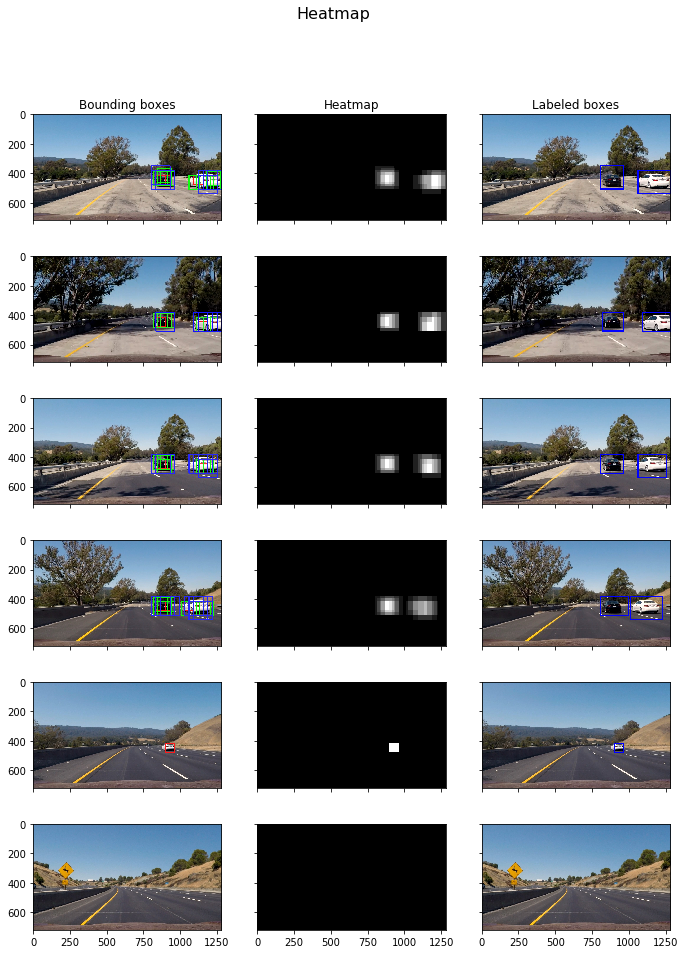

In [20]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heatmap_imgs = []
for img in test_images:
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    #heatmap_imgs.append(img)
    #img = img.astype(np.float32)/255
    out_img, found_windows = find_cars(img, windows)
    #box_img = draw_boxes(img, found_windows, color=(255, 0, 0), thick=6)
    heatmap_imgs.append(out_img)
    for win in found_windows:
        heat = add_heat(heat, [win])
    #heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    heatmap_imgs.append(heatmap)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    heatmap_imgs.append(draw_img)
    
draw_grid(heatmap_imgs, "Heatmap", heatmap_imgs[0].shape, 3, 20, None, [["Bounding boxes", "Heatmap", "Labeled boxes"],[]])

## Video Implementation

**1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)**

The final video is displayed in one of the following code cells and output as `project_video_out.mp4`.

In [13]:
# From https://carnd-forums.udacity.com/questions/32706990/want-to-create-a-diagnostic-view-into-your-lane-finding-pipeline
def normalized(img):
    return np.uint8(255*img/np.max(np.absolute(img)))

def to_RGB(img):
   if img.ndim == 2:
       img_normalized = normalized(img)
       return np.dstack((img_normalized, img_normalized, img_normalized))
   elif img.ndim == 3:
       return img
   else:
       return None

def compose(curverad=0, offset=0, mainDiagScreen=None,
                     diag1=None, diag2=None, diag3=None, diag4=None, diag5=None, diag6=None, diag7=None, diag8=None, diag9=None):
      ## middle panel text example
      ## using cv2 for drawing text in diagnostic pipeline.
      #font = cv2.FONT_HERSHEY_COMPLEX
      middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
      #cv2.putText(middlepanel, 'Estimated lane curvature: {}'.format(curverad), (30, 60), font, 1, (255,0,0), 2)
      #cv2.putText(middlepanel, 'Estimated Meters right of center: {}'.format(offset), (30, 90), font, 1, (255,0,0), 2)

      # assemble the screen example
      diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
      if mainDiagScreen is not None:
            diagScreen[0:720, 0:1280] = mainDiagScreen
      if diag1 is not None:
            diagScreen[0:240, 1280:1600] = cv2.resize(to_RGB(diag1), (320,240), interpolation=cv2.INTER_AREA) 
      if diag2 is not None:
            diagScreen[0:240, 1600:1920] = cv2.resize(to_RGB(diag2), (320,240), interpolation=cv2.INTER_AREA)
      if diag3 is not None:
            diagScreen[240:480, 1280:1600] = cv2.resize(to_RGB(diag3), (320,240), interpolation=cv2.INTER_AREA)
      if diag4 is not None:
            diagScreen[240:480, 1600:1920] = cv2.resize(to_RGB(diag4), (320,240), interpolation=cv2.INTER_AREA)
      if diag5 is not None:
            diagScreen[600:1080, 1280:1920] = cv2.resize(to_RGB(diag5), (640,480), interpolation=cv2.INTER_AREA)
      diagScreen[720:840, 0:1280] = middlepanel
      if diag6 is not None:
            diagScreen[840:1080, 0:320] = cv2.resize(to_RGB(diag6), (320,240), interpolation=cv2.INTER_AREA)
      if diag7 is not None:
            diagScreen[840:1080, 320:640] = cv2.resize(to_RGB(diag7), (320,240), interpolation=cv2.INTER_AREA)
      if diag8 is not None:
            diagScreen[840:1080, 640:960] = cv2.resize(to_RGB(diag8), (320,240), interpolation=cv2.INTER_AREA)
      if diag9 is not None:
            diagScreen[840:1080, 960:1280] = cv2.resize(to_RGB(diag9), (320,240), interpolation=cv2.INTER_AREA)

      return diagScreen

**2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.**

The `Filter` class in the following code cell is used to filter false positives by examining the windows from multiple frames (in this case, 3). The threshold function that is applied to the heatmap uses a higher threshold value depending on the number of frames in the circular buffer, which allows it to eliminate false positives that appear only in a single frame.

The overlapping bounding boxes are eliminated by running `scipy.ndimage.measurements.label` on the final heatmap and then detecting bounding boxes for each blob in the labeled heatmap, as described in the course notes.

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import collections

prvs = np.zeros_like(img[:,:,0]).astype(np.float)
hsv = np.zeros_like(img)
hsv[...,1] = 255

prvs_heat = np.zeros_like(img[:,:,0]).astype(np.float)
hsv_heat = np.zeros_like(img)
hsv_heat[...,1] = 255

def mask_image(img, mask):
    """Apply a mask to an image"""
    return cv2.bitwise_and(img, img, mask=mask)

class Filter:
    def __init__(self):
        self.previous_bboxes = collections.deque(maxlen = 5)
        
    def add_heat(self, heatmap):
        # Iterate through list of bboxes
        for bbox_list in self.previous_bboxes:
            for box in bbox_list:
                # Add += 1 for all pixels inside each bbox
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                box_size = box[1][1] - box[0][1]
                bonus = 0
                if box_size <= 64:
                    bonus = 2
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1 + bonus
        # Return updated heatmap
        return heatmap# Iterate through list of bboxes 
    
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    def update(self, img):
        img = toRGB(img)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        out_img, found_windows = find_cars(img, windows)
        self.previous_bboxes.append(found_windows)
        self.previous_bboxes.append(found_windows)
        
        heat = self.add_heat(heat)
        
        heat_before_threshold = np.copy(heat)
        
        heat = self.apply_threshold(heat, len(self.previous_bboxes) + 1)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        out = compose(0, 0, draw_img, heat, heat_before_threshold, img, img, out_img, mask_image(img, cv2.threshold(cv2.cvtColor(to_RGB(heat), cv2.COLOR_BGR2GRAY), 1, 256, cv2.THRESH_BINARY)[1]))
        #draw_image(out, "Frame")
        
        prvs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        prvs_heat = heatmap
        
        return out

def process_frame(img):
    global prvs, hsv, prvs_heat, hsv_heat
    img = toRGB(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    out_img, found_windows = find_cars(img, windows)
    heat = add_heat(heat, found_windows)
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    flow = cv2.calcOpticalFlowFarneback(prvs, cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    
    flow_heat = cv2.calcOpticalFlowFarneback(prvs_heat, heatmap, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow_heat[...,0], flow_heat[...,1])
    hsv_heat[...,0] = ang*180/np.pi/2
    hsv_heat[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb_heat = cv2.cvtColor(hsv_heat,cv2.COLOR_HSV2BGR)
    
    
    out = compose(0, 0, draw_img, heatmap, rgb_heat, prvs, rgb, out_img, mask_image(img, cv2.threshold(cv2.cvtColor(to_RGB(heat), cv2.COLOR_BGR2GRAY), 1, 256, cv2.THRESH_BINARY)[1]))
    #draw_image(out, "Frame")
    
    prvs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    prvs_heat = heatmap
    
    return out

def process_video(input_path, output_path, start=None, end=None):
    filt = Filter()
    if start == None and end == None:
        clip = VideoFileClip(input_path)
    else:
        clip = VideoFileClip(input_path).subclip(start, end)
    output_clip = clip.fl_image(lambda x: filt.update(toRGB(x)))
    output_clip.write_videofile(output_path, audio=False)


In [ ]:
process_video("test_video.mp4", "test_video_out.mp4")

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_out.mp4"))


In [16]:
process_video("project_video.mp4", "project_video_out2.mp4", 23, 26)

[MoviePy] >>>> Building video project_video_out2.mp4
[MoviePy] Writing video project_video_out2.mp4


 99%|█████████▊| 75/76 [03:06<00:02,  2.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out2.mp4 



In [17]:
process_video("project_video.mp4", "project_video_out.mp4")

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [52:08<00:02,  2.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_out.mp4"))


---

## Discussion

**1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?**


The main issue faced during this project was eliminating false positives. The classifier is very sensitive to features on the road and will occassionally detect features on the lane lines or transition from light to dark patches of the road.

It also fails in cases where the color of the car is very similar to the color of the road, and the car is off in the distance. In this case, it is difficult for the classifier to differentiate between the car and the road.

In order to make the project more robust, an estimator (Kalman filter?) could be used to track the location of each detected vehicle between frames and predict the future location of vehicles. This could be used to eliminate false positives by removing windows that were not found within some reasonable range of the predicted future location.

A lot of work could be done to improve the speed of the vehicle detection. This could include the following:
* Only calculate HOG features once per frame.
* Scale the entire frame for each window size rather than cropping and then scaling each window to 64x64. This would significantly reduce the number of times images must be re-scaled during processing.
* Only scan windows in regions of the image that have changed signficiantly between frames. This would eliminate the need to spend time trying to detect features in regions where cars were not recently detected, as it is fairly unlikely that cars will randomly materialize somewhere in the middle of the frame if they weren't previously detected near there. 